In [1]:
import sys

sys.path.append("../")
from hamilton_neural_network import (
    TrainTestData,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import NegLogIndepedentGaussians, NegLogNealFunnel
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling

tf.random.set_seed(0)

2.18.0


In [2]:
U = NegLogNealFunnel()
K = NegLogIndepedentGaussians(tf.constant([0.0, 0.0]), tf.constant([1.0, 1.0]))
q0 = tf.constant([[0.0, 0.0]])
p0 = tf.random.normal(q0.shape)
T = 120.0
leap_frog_per_unit = 40
num_samples = 40
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

In [3]:
train_test_data = TrainTestData(num_samples, T, leap_frog_per_unit, q0, p0, U=U, K=K)
samples = train_test_data()
tf.io.write_file("../exps/demo3_train_test_data.txt", tf.io.serialize_tensor(samples))

Generating samples...
Finished generating samples.


In [ ]:
file = tf.io.read_file("../exps/demo3_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_test_data = tf.random.shuffle(train_test_data)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
print(train_data.shape, test_data.shape)
lhnn = LatentHamiltonianNeuralNetwork(3, 100, 2)
lhnn.build(input_shape=(1, 4))
train_hist, test_hist = lhnn.train(
    2000, 1000, 1e-4, train_data, test_data, save_dir="../exps/demo3_lhnn.weights.h5", print_every=100
)

(172800, 8) (19240, 8)
Training started...
Epoch 0: Train loss 0.403550386428833, Test loss 0.3856024146080017.
Epoch 100: Train loss 0.0003514651907607913, Test loss 0.0004271980724297464.
Epoch 200: Train loss 0.0002214057749370113, Test loss 0.00030884213629178703.
Epoch 300: Train loss 0.00014933130296412855, Test loss 0.00013834430137649179.
Epoch 400: Train loss 0.0005194630939513445, Test loss 0.0005558570846915245.
Epoch 500: Train loss 0.00026655278634279966, Test loss 0.0001923988020280376.
Epoch 600: Train loss 0.0004676851676777005, Test loss 0.00031135656172409654.
Epoch 700: Train loss 9.031418449012563e-05, Test loss 6.913411925779656e-05.
Epoch 800: Train loss 0.0001356896391371265, Test loss 8.527073805453256e-05.
Epoch 900: Train loss 0.00029974401695653796, Test loss 0.0003426982439123094.
Training complete!


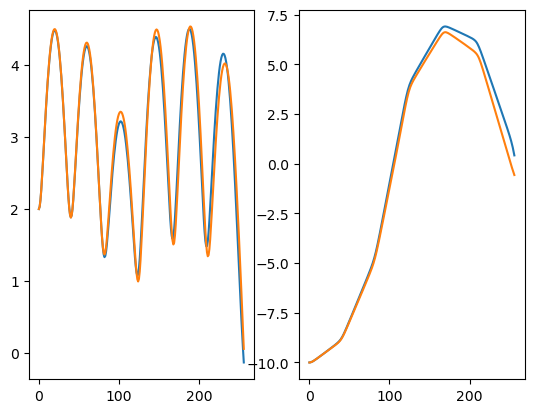

In [16]:
lhnn = LatentHamiltonianNeuralNetwork(3, 100, 2)
lhnn.build(input_shape=(1, 4))
lhnn.load_weights("../exps/demo3_lhnn.weights.h5")
U = NegLogNealFunnel()
K = NegLogIndepedentGaussians(tf.constant([0.0, 0.0]), tf.constant([1.0, 1.0]))
q0 = tf.constant([[2.0, -10.0]])
p0 = tf.constant([[0.0, 0.0]])
leap_frog_per_unit = 5
n_steps = 256
original_hamiltonian = HamiltonianSystem(U=U, K=K)

hist_original = original_hamiltonian.symplectic_integrate(
    q0, p0, 1 / leap_frog_per_unit, n_steps
)
hist_lhnn = lhnn.symplectic_integrate(q0, p0, 1 / leap_frog_per_unit, n_steps)

fig, ax = plt.subplots(1, 2)
ax[0].plot(hist_original[:, 0])
ax[0].plot(hist_lhnn[:, 0])
ax[1].plot(hist_original[:, 1])
ax[1].plot(hist_lhnn[:, 1])
plt.show()

In [ ]:
lhnn = LatentHamiltonianNeuralNetwork(3, 100, 2)
lhnn.build(input_shape=(1, 4))
lhnn.load_weights("../exps/demo3_lhnn.weights.h5")
q0 = tf.constant([[0.0, 0.0]])
nuts = NoUTurnSampling(
    num_samples=25000,
    q0=q0,
    dt=0.2,
    lhnn=lhnn,
    Hamiltonian=HamiltonianSystem(U=U, K=K),
    Delta_lf=1000.0,
    Delta_lhnn=10.0,
    num_lf_steps=20,
    j_max=13
)
nuts(print_every=1250)
print(nuts.lhnn_call)
print(nuts.Hamiltonian_gradient_call)
q_hist = tf.concat(nuts.q_hist, axis=0)
tf.io.write_file("../exps/demo3_q_hist.txt", tf.io.serialize_tensor(q_hist))

Sample 0 of 25000
Sample 1250 of 25000
Sample 2500 of 25000


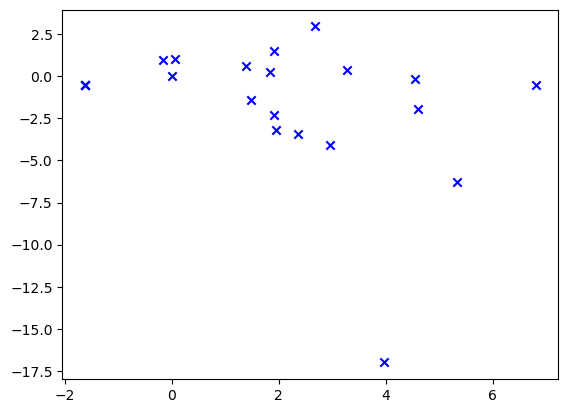

In [17]:
plt.scatter(q_hist.numpy()[:, 0].flatten(), q_hist.numpy()[:, 1].flatten(), color="blue", marker="x")
plt.show()